In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import sys
import librosa
import numpy as np
import torch
import torch.onnx
from torch.nn import functional as F
import numpy as np
from tqdm.notebook import tqdm
sys.path.insert(0, "/home/shahn/Documents/trainer")
from models.encodec.default.models import EncodecModel as Encodec
from models.encodec.default.streaming import Encodec as EncodecOnnx
from utils import get_hparams
from models import get_wrapper
import librosa
import IPython.display as ipd

In [2]:
model = EncodecOnnx(24_000)
model.eval()
SR = model.sample_rate

url = "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th"
state_dict = torch.hub.load_state_dict_from_url(url, map_location='cpu', check_hash=True)
new_state_dict = {}
for name, param in state_dict.items():
    if "inited" in name:
        continue
    if "embed_avg" in name:
        continue
    if "quantizer" in name:
        name = name.replace(".vq", "").replace("._codebook", "").replace("cluster_size", "ema_num")
        new_state_dict[name.replace("quantizer", "dequantizer")] = param
    elif "conv.conv." in name:
        name = name.replace("conv.conv.", "")
    elif "convtr.convtr." in name:
        name = name.replace("convtr.convtr.", "")
    elif "lstm" in name:
        name = name.replace("lstm.", "")
    new_state_dict[name] = param
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [22]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

torch.set_num_threads(1)
hop_size = 320
wav = librosa.load("../onnx/input_speech.wav", sr=SR)[0][:SR*5]
wav = torch.from_numpy(wav).view(1,1,  -1).clamp(min=-1, max=1)
length = wav.size(-1) // hop_size * hop_size
wav = wav[:,:,:length]
wav_in = wav[:, :, :hop_size]
print("cache initialized!")

cache initialized!


  0%|          | 0/375 [00:00<?, ?it/s]

enc_time: 3.8 sec / rtf: 1.3010500663231694 (↑)
dec_time: 4.1 sec / rtf: 1.2247181966287348 (↑)
total: 7.9 sec / rtf: 0.6308653546421372 (↑)


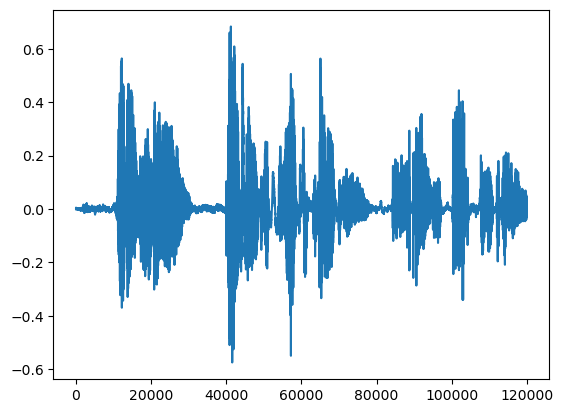

### Out:

### In:

In [19]:
wav_out_list = []
enc_time, dec_time = 0., 0.
st = time.perf_counter()
with torch.no_grad():
    for i in tqdm(range(0, length, hop_size)):
        wav_in = wav[:, :, i:i+hop_size]
        x, cache_enc = model.encoder(wav_in, *cache_enc)
        indices = model.quantizer(x, 8)
        et = time.perf_counter()
        enc_time += et - st
        st = et
        q = model.dequantizer(indices, 8)
        wav_out, cache_dec = model.decoder(q, *cache_dec)
        et = time.perf_counter()
        dec_time += et - st
        st = et
        wav_out_list.append(wav_out.squeeze(1).clamp(min=-1, max=1))
et = time.perf_counter()
print(f"enc_time: {enc_time:.1f} sec / rtf: {length/SR / enc_time} (↑)")
print(f"dec_time: {dec_time:.1f} sec / rtf: {length/SR / dec_time} (↑)")
total = enc_time + dec_time
print(f"total: {total:.1f} sec / rtf: {length/SR / total} (↑)")

wav_out = torch.cat(wav_out_list, dim=1)[0].numpy()
plt.plot(wav_out)
plt.show()
ipd.display(ipd.Markdown('### In:'), ipd.Audio(wav.numpy().squeeze(), rate=SR, normalize=False))
ipd.display(ipd.Markdown('### Out:'), ipd.Audio(wav_out, rate=SR, normalize=False))
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))

# Export

In [21]:
cache_enc, cache_dec = model.initialize_cache(torch.randn(1))
NAME = "encodec"
BASE_DIR = '../onnx'
### Encoder ###
dynamic_axes = dict(wav_in={0: 'batch', 2: 'time'})
dynamic_axes.update({f"e_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
dynamic_axes.update({f"e_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_enc))})
torch.onnx.export(
    model.encoder,
    (wav_in, *cache_enc),
    f"{BASE_DIR}/{NAME}_enc.onnx",
    input_names = ['wav_in'] + [f'e_in{i}' for i in range(len(cache_enc))],
    output_names = ['x'] + [f'e_out{i}' for i in range(len(cache_enc))],
    dynamic_axes = dynamic_axes,
    opset_version=17
)
cache_enc_dict = {f"e_in{i}": e.numpy() for i, e in enumerate(cache_enc)}
np.savez(f'{BASE_DIR}/{NAME}_cache_enc.npz', **cache_enc_dict)

### Quantizer ###
for idx, vq in enumerate(model.quantizer.layers):
    torch.onnx.export(
        vq,
        (x,),
        f"{BASE_DIR}/{NAME}_vq{idx}.onnx",
        input_names = ['x'],
        output_names = ['q', 'idx'],
        dynamic_axes={"x": {0: "batch", 1: "time"}}
    )

### Dequantizer ###
for idx, deq in enumerate(model.dequantizer.layers):
    torch.onnx.export(
        deq,
        (indices[0],),
        f"{BASE_DIR}/{NAME}_deq{idx}.onnx",
        input_names = ['idx'],
        output_names = ['q'],
        dynamic_axes={"idx": {0: "batch", 1: "time"}}
    )

### Decoder ###
dynamic_axes = dict(q={0: 'batch', 1: 'time'})
dynamic_axes.update({f"d_in{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
dynamic_axes.update({f"d_out{i}": {0: "batch", 2:"time"} for i in range(len(cache_dec))})
torch.onnx.export(
    model.decoder,
    (x, *cache_dec),
    f"{BASE_DIR}/{NAME}_dec.onnx",
    input_names = ['q'] + [f'd_in{i}' for i in range(len(cache_dec))],
    output_names = ['wav_out'] + [f'd_out{i}' for i in range(len(cache_dec))],
    dynamic_axes = dynamic_axes
)
cache_dec_dict = {f"d_in{i}": e.numpy() for i, e in enumerate(cache_dec)}
np.savez(f'{BASE_DIR}/{NAME}_cache_dec.npz', **cache_dec_dict)
print("onnx ported!")

onnx ported!
